# Oscilador armónico - Red Neuronal informada por física (PINN)

Extraído de https://github.com/hubertbaty/PINNS-EDO/blob/main/pinn-an-fig13.ipynb y ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

Ecuacion:

\begin{equation}
 \frac {d^2y} {dt^2} + \omega_0^2 y= 0, \\
 \end{equation}

Solución exacta:

\begin{equation}
 y(t) = \exp^{-\delta t} (2 A cos(\phi + \omega t)) \\
\end{equation}


In [10]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [11]:
# Exact solution ..................................................................
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

# def oscillatorb(d, w0, x):
#     assert w0 < d
#     w = np.sqrt(d**2-w0**2)
#     exp1 = torch.exp(-d*x)
#     exp2 = torch.exp(w*x)
#     c1 = 1/2*(1+d/w)
#     c2 = 1/2*(1-d/w)
#     y = exp1*(c1*exp2+c2/exp2)   
#     return y

# Normal network ...........................................
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

<!-- ## Generar datos de entrenamiento -->

> Primero, se generan algunos datos de entrenamiento de una pequeña parte de la verdadera solución analítica

Para este problema, usamos $\delta=0$, $\omega_0=20$, e intentamos aprender la solución sobre el dominio $x\in [0,1]$.

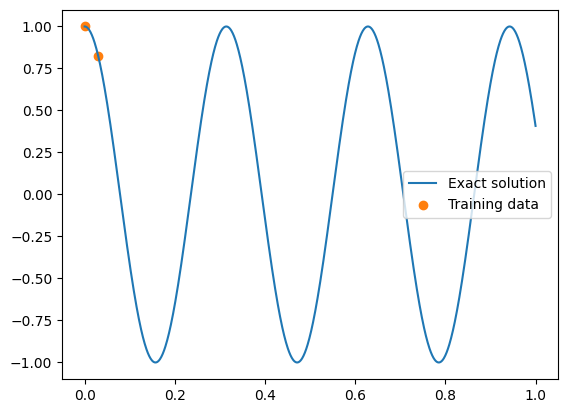

In [12]:
# We generate the exact solution and the training data ...................
d, w0 = 0., 20.
# get the analytical solution over the full domain ......................
x = torch.linspace(0,1,1000).view(-1,1)

y = oscillator(d, w0, x).view(-1,1)
yn=y

# slice out a small number of points -> training data (2 points here) ..........
x_data = x[0:60:30] # 
y_data = y[0:60:30]



plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Red neuronal normal

> Siguiente, entrenamos una red neuronal estándar (la red totalmente conectada) para ajustarla sobre estos puntos.

>Encontramos que la red es capaz de ajustar la solución muy cercanamente de un conjunto de puntos de entrenamiento, pero no aprende una solución precisa fuera de ellos.

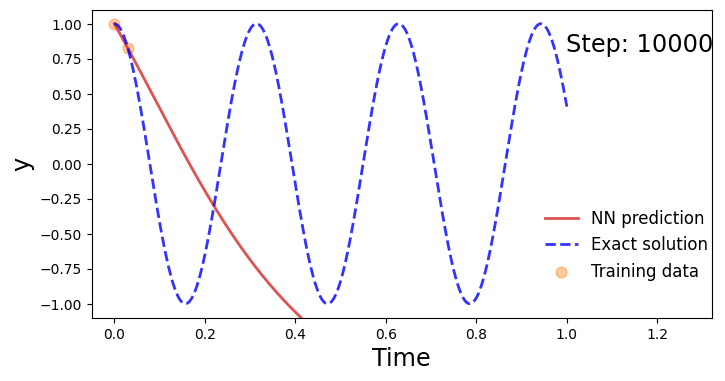

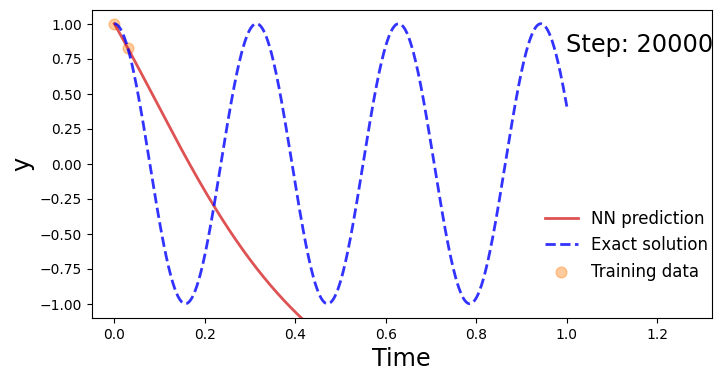

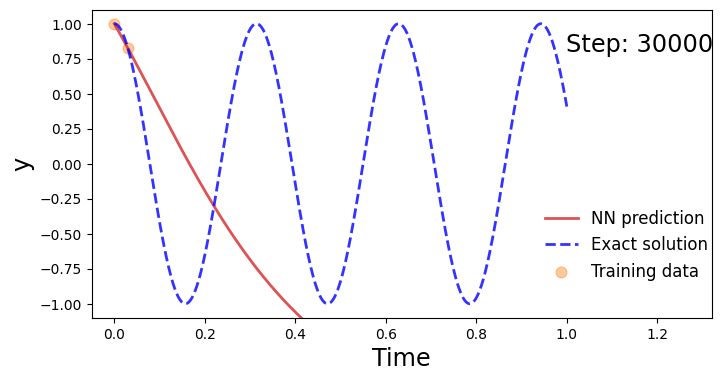

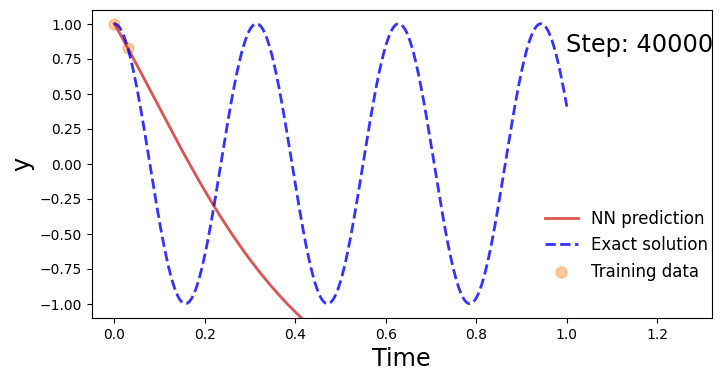

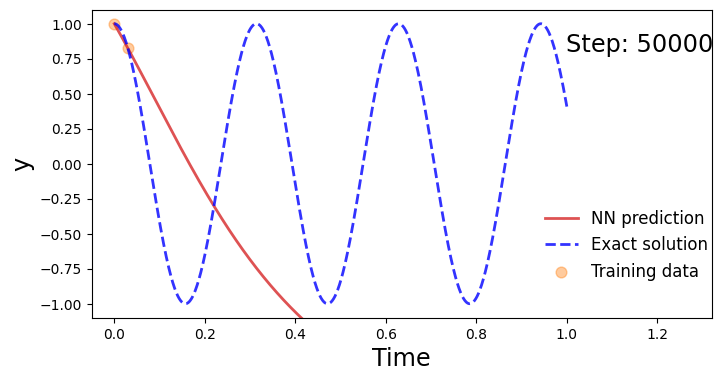

In [13]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x,y, color="blue", linewidth=2, alpha=0.8,linestyle='--', label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Coloc. points')
    l = plt.legend(loc=(0.72,0.1), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.32)
    plt.ylim(-1.1, 1.1)
    plt.text(0.998,0.8,"Step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.ylabel('y',fontsize="xx-large")
    plt.xlabel('Time',fontsize="xx-large")
    plt.axis("on")
        
# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)
files = []

loss11_history = []

for i in range(54000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
        
    # plot the result as training progresses
    if (i+1) % 100 == 0: 
        
        loss11_history.append(loss.detach())  
        yh = model(x).detach()        
        plot_result(x,y,x_data,y_data,yh)
    
        if (i+1) % 10000 == 0: plt.show()
        else: plt.close("all")
            

# PINN

> Finalmente, añadimos la ecuación diferencial ("Pérdida física") a la función de pérdida.

La pérdida física se asegura que la solución aprendida es consistente con la ecuación diferencial. Esto es hecho penalizando el residuo de la ecuación deiferencial sobre un conjunto de localizaciones muestreadas desde el dominio.

Aquí evaluamos la pérdida física en 40 puntos uniformemente espaciados sobre el dominio del problema $([0,1])$. Podemos calcular las derivadas de la solución de la red con respecto a las variables de entrada en estos puntos usando la autodiferenciaciónde `pytorch`, y podemos calcularlas fácilmente los residuales de la ecuación diferencial usando estas cantidades.  

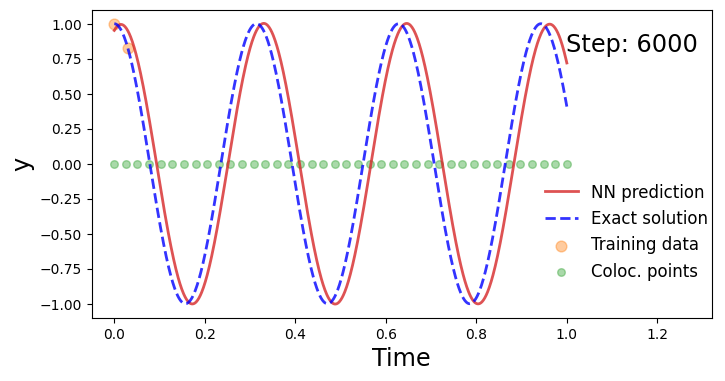

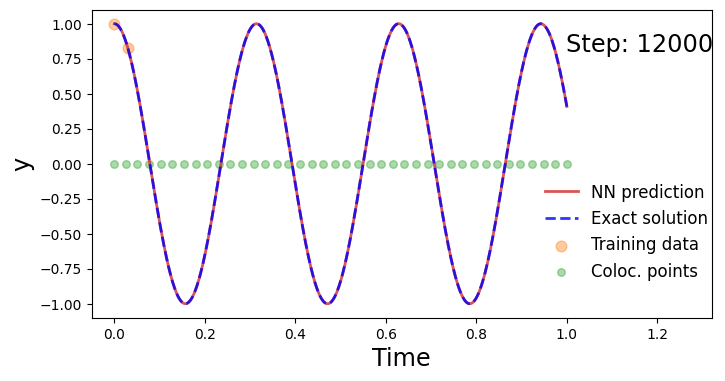

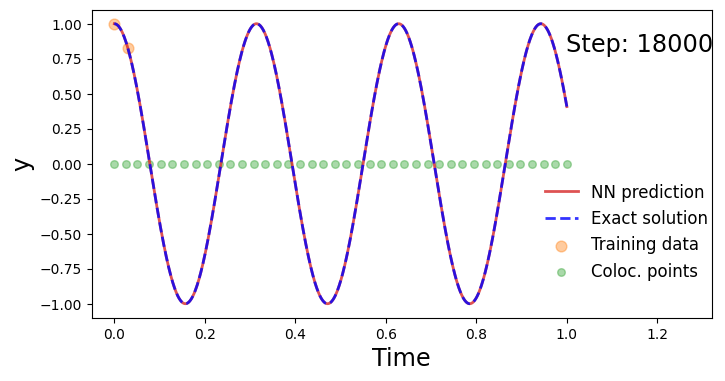

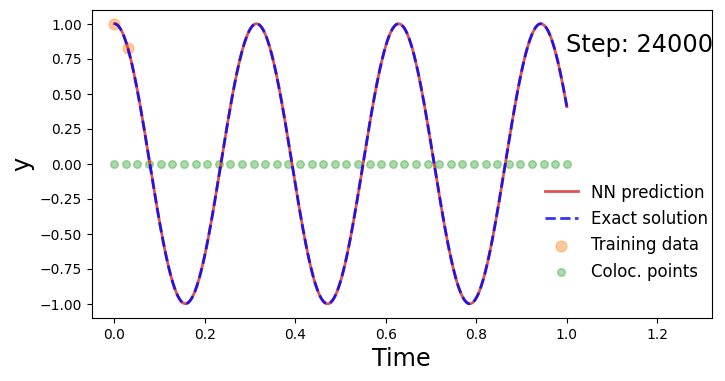

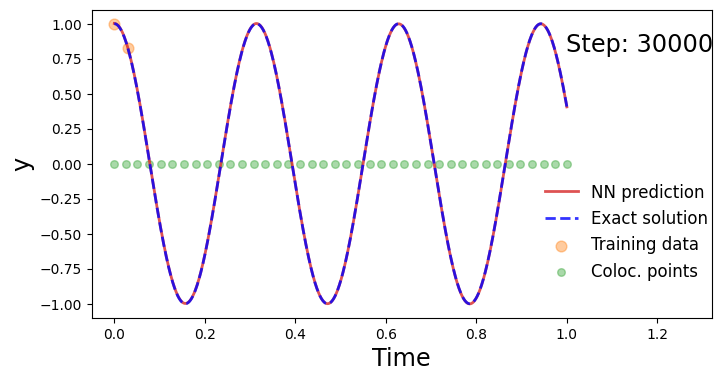

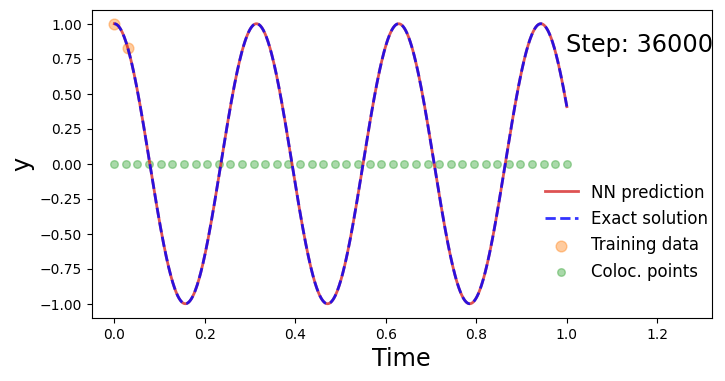

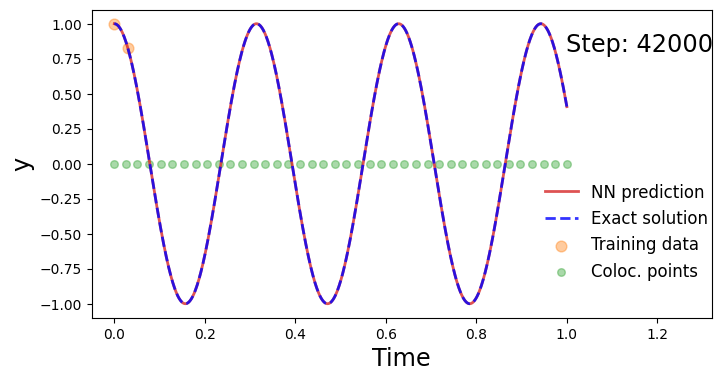

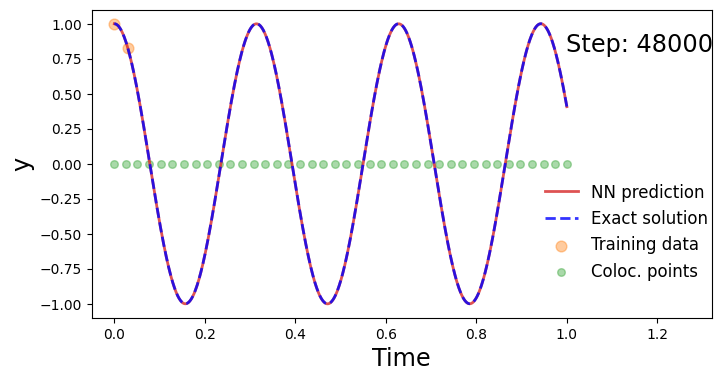

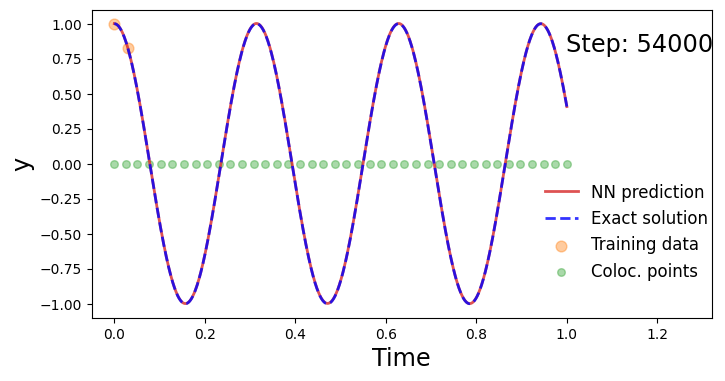

In [6]:
# We define the collocation points ......................................................................
x_physics = torch.linspace(0,1,40).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
files = []
loss1_history = []
loss2_history = []
loss3_history = []
loss_history = []
mse_history = []

for i in range(54000):
    optimizer.zero_grad()
    
    # We compute the "data loss" ...................................................................
    yh = model(x_data)
    loss1 = 1.*torch.mean((yh-y_data)**2)# use mean squared error
    
    # We compute the "physics loss"...............................................................
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = (dx2 + mu*dx + k*(yhp))# computes the residual of the harmonic oscillator differential equation
    loss2 = 3.e-4*torch.mean(physics**2)
    
    # We compute the "energy loss" for dy/dt (t=0) =0 ........................................
    physics2 = (dx**2/2. + w0**2*yhp**2/2. - w0**2/2.)
    loss3 = 3.e-4*torch.mean(physics2**2)
    
    yhpp=model(x)
    mse=torch.mean((yhpp-y)**2)
    
    # We backpropagate total loss ..............................
    loss = loss1 + loss2 + loss3     # add loss terms together
    loss.backward()
    optimizer.step()
       
    # plot the result as training progresses ..................
    if (i+1) % 100 == 0: 
        loss1_history.append(loss1.detach())
        loss2_history.append(loss2.detach())
        loss3_history.append(loss3.detach())
        loss_history.append(loss.detach())
        mse_history.append(mse.detach())
        
        yh = model(x).detach()
        xp = x_physics.detach()
                
        plot_result(x,y,x_data,y_data,yh,xp)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            

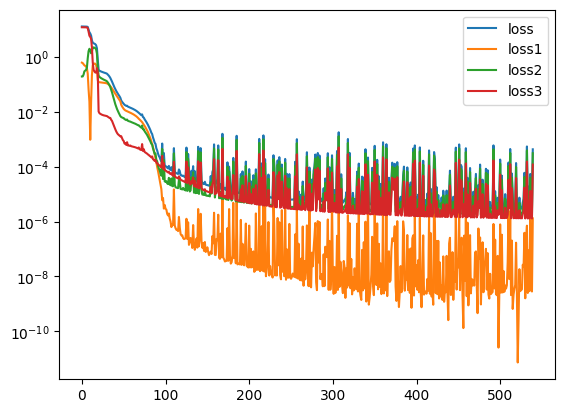

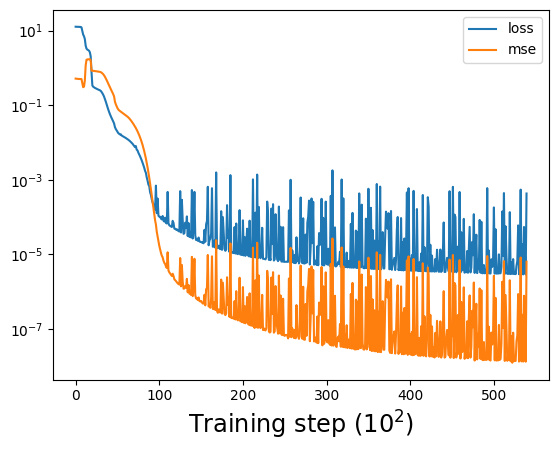

In [7]:
plt.plot(loss_history, label="loss")
plt.yscale('log')
plt.legend()

plt.plot(loss1_history, label="loss1")
plt.yscale('log')
plt.legend()

plt.plot(loss2_history, label="loss2")
plt.yscale('log')
plt.legend()

plt.plot(loss3_history, label="loss3")
plt.yscale('log')
plt.legend()

fig33 = plt.figure(33)
plt.plot(loss_history, label="loss")
plt.plot(mse_history, label="mse")
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.yscale('log')
plt.legend()

tensor(2.4593e-06)
tensor(0.0025)


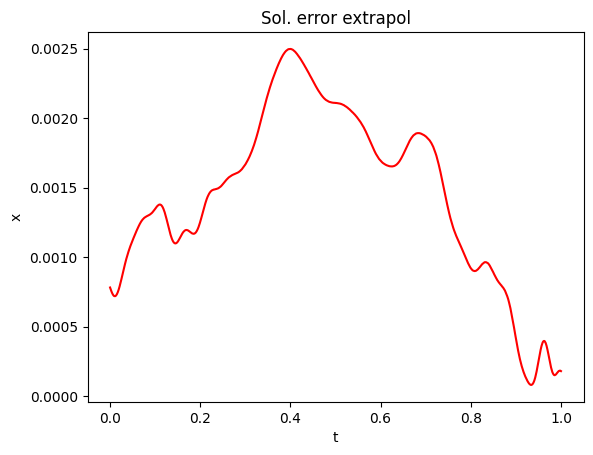

<Figure size 640x480 with 0 Axes>

In [8]:
xn = torch.linspace(0.,1.,1000).view(-1,1)

yh2 = model(xn).detach()
        
# plot extrapolate    
fig5 = plt.figure(5)
plt.plot(xn, yh2-y, color="red")
#plt.plot(x, y)
#plt.plot(xn, yth)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Sol. error extrapol")


fig6 = plt.figure(6)
toto=yh2-y
toto2=  torch.mean((yh2 - y)**2)
toto3= torch.max(abs(yh2-y))
print(toto2)
print(toto3)
